In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from astropy import units as u
from astropy.table import join, Table

import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn

from catalogues import Catalogue

import swasputils

In [3]:
superwasp_sources = swasputils.UnifiedSubjects().get_workflow(swasputils.MAIN_WORKFLOW).df
#superwasp_sources = swasputils.UnifiedSubjects().get_workflow(swasputils.MAIN_WORKFLOW).real.df
superwasp_sources['SuperWASP Coords'] = superwasp_sources['SWASP ID'].replace(r'^1SWASP', '', regex=True)

In [4]:
harmonic_groups = pandas.read_pickle(os.path.join(swasputils.CACHE_LOCATION, 'harmonic_groups.pickle'))

In [5]:
superwasp_periods = Table.from_pandas(superwasp_sources.merge(harmonic_groups)[['Period', 'SuperWASP Coords', 'Harmonic Group']])

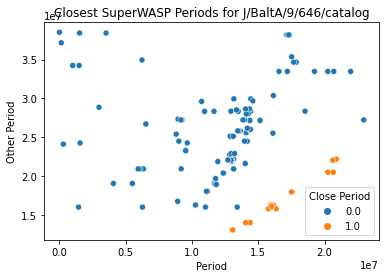

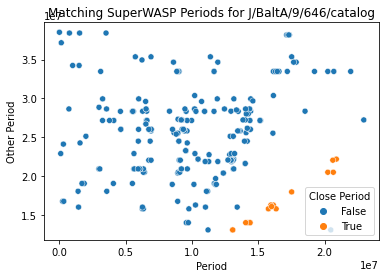

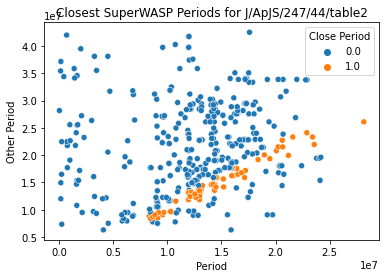

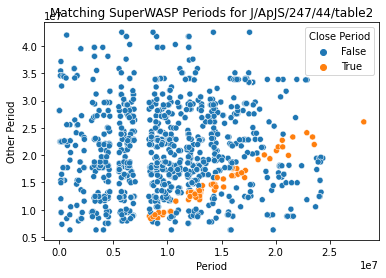

In [10]:
catalogue_matches = {}
for catalogue in Catalogue.all():
    matched_table = catalogue.matched_table
    matched_table['Other Period'] = matched_table[catalogue.per_col].to(u.second)
    matched_periods_all = join(matched_table[['Other Period', 'SuperWASP Coords']], superwasp_periods, join_type='inner').to_pandas()
    matched_periods_all = matched_periods_all[matched_periods_all['Other Period'] < 5e7]
    matched_periods_all['Close Period'] = numpy.isclose(
        matched_periods_all['Period'],
        matched_periods_all['Other Period'],
        atol=0,
        rtol=1e-1, # To do: Figure out a justifiable value for this!
    )
    
    matched_periods = pandas.DataFrame()
    
    for group_name, group_periods in matched_periods_all.groupby('SuperWASP Coords'):
        # Keep the closest period
        matched_periods = matched_periods.append(
            group_periods.loc[
                numpy.abs(
                    group_periods['Period'] - group_periods['Other Period']
                ).idxmin()
            ]
        )

    matched_periods['log(Period)'] = numpy.log10(matched_periods['Period'])
    matched_periods['log(Other Period)'] = numpy.log10(matched_periods['Other Period'])
    matched_periods['Ratio'] = matched_periods['Other Period'] / matched_periods['Period']
    matched_periods['log(Ratio)'] = numpy.log10(matched_periods['Ratio'])
    
    catalogue_matches[catalogue.name] = {
        'closest': matche
    
    seaborn.scatterplot(
        data=matched_periods,
        x='Period',
        y='Other Period',
        hue='Close Period',
    ).set(title=f'Closest SuperWASP Periods for {catalogue}')
    plt.show()
    
    seaborn.scatterplot(
        data=matched_periods_all,
        x='Period',
        y='Other Period',
        hue='Close Period',
    ).set(title=f'Matching SuperWASP Periods for {catalogue}')
    plt.show()

    #seaborn.displot(data=matched_periods, x="log(Ratio)").set(title=f'SuperWASP Period Ratios for {catalogue}')
    #plt.show()
    
    #seaborn.countplot(data=matched_periods, x='Close Period').set(title=f'Period Closeness {catalogue}')
    #plt.show()